In [4]:
import subprocess
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import defaultdict
import matplotlib.gridspec as gridspec
import string

alphabet = list(string.ascii_lowercase)

In [5]:
def query_db(query, args=''):
    cmd = "mysql {} -e \"{}\"".format(args, query)
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if p.returncode > 0:
        print("Failed to query database with error:")
        print(p.stderr.decode())
    else:
        df = pd.read_csv(StringIO(p.stdout.decode()), sep='\t')
        return df
    
p1 = re.compile(r'(\w+)\/(\w+\_end)\/((E|D|S)RR[0-9]{6,})')
p4 = re.compile(r'(\w+)\/((E|D|S)RR[0-9]{6,})')
p2 = re.compile(r'(.+\))\:\s(.+)')
p3 = re.compile(r'signal\s(\d+)')

def parse_time(fname):
    
    d = defaultdict(dict)
    
    with open(fname, 'r') as f:
        for l in f.readlines():
            l = l.strip()
            if l.startswith('==>'):
                m = p1.findall(l)
                if len(m) > 0:
                    rule, read_type, accession, _ = m[0]
                else:
                    read_type = pd.NA
                    m = p4.findall(l)
                    rule, accession, _ = m[0]

                d[rule][accession] = {'read_type': read_type}

            elif 'terminated' in l:
                d[rule][accession]['terminated_signal'] = int(p3.findall(l)[0])
            elif ':' in l:
                ls = l.split(':')
                if len(ls) == 2:
                    try:
                        d[rule][accession][ls[0]] = float(ls[1])
                    except:
                        d[rule][accession][ls[0]] = ls[1]
                else:
                    m = p2.findall(l)
                    d[rule][accession][m[0][0]] = m[0][1]

    df = pd.DataFrame.from_dict({(i,j): d[i][j] 
                           for i in d.keys() 
                           for j in d[i].keys()},
                       orient='index')
    df.index.names = ['rule', 'sample']
    df['file'] = fname

    if 'terminated_signal' in df.columns:
        df['terminated_signal'].fillna(0, inplace=True)
        
    
    # create cpu time measurements
    df['cpu_time_s'] =df['User time (seconds)'] + df['System time (seconds)']
    df['cpu_time_h'] =df['cpu_time_s'] / 3600
    
    df['tool'] = df['Command being timed'].apply(lambda x: x.split(' ')[1].replace('"', '') if isinstance(x, str) else pd.NA)
    
    # where bbduk is the tool find out whether output was zipped or not
    df.loc[
        df['tool'] == 'bbduk.sh', 'tool'
    ] = df.loc[
        df['tool'] == 'bbduk.sh', 'Command being timed'
    ].str.count('gz').isin([2,4]).apply(
        lambda x: 'bbduk.sh zipped' if x else 'bbduk.sh'
    )
    
    #kbytes to gigabytes
    df['Maximum resident set size (gb)'] = df['Maximum resident set size (kbytes)'] * 10**(-7)
    
    return df.reset_index()

def figure_saver(fig, prefix, contexts=['paper'], formats=['.png', '.pdf', '.tiff']):
    
    for context in contexts:
        
        for fformat in formats:
            fname = f"{prefix}_{context}{fformat}"
            fig.savefig(fname,  bbox_inches = "tight")
    
    sns.set_context('paper')

def get_cmap(labels, name='viridis'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    cmap = plt.get_cmap(name, len(labels))#.colors
    
    return {l: cmap(i) for i, l in enumerate(labels)}

In [10]:
dfs = {
    '32': parse_time('data/AvA_32.times'),
    '29_fastp': parse_time('data/29_fastp.times'),
}

In [11]:
samples29 = [
    'ERR056997', 'ERR1135612', 'ERR1884262','ERR209998',
    'ERR2239761', 'ERR262503', 'ERR2764819', 'ERR299538',
    'ERR3213717', 'ERR3593315', 'ERR3641954', 'SRR10154308',
    'SRR10158848', 'SRR1027651', 'SRR1044677', 'SRR1179181',
    'SRR1524512', 'SRR2094831', 'SRR2237446', 'SRR3434587',
    'SRR3989182', 'SRR4929941', 'SRR5950773', 'SRR6401741',
    'SRR7125621', 'SRR7533096', 'SRR7992574', 'SRR7992575',
    'SRR9178241',
]



# Comparing times for trimming of reads

A comparison between bbduk.sh with zipping of output, bbduk.sh without zipping of output, and fastp.

In [12]:
trimTimes = pd.concat(
    [
        dfs['32'].query(f"sample in @samples29 & rule  in ('trimmed_reads', 'trimmed_reads_unzipped')"), 
        dfs['29_fastp'],

    ]
)

trimTimesP = trimTimes.pivot_table(index=['sample', 'rule'], values=['cpu_time_h', 'Maximum resident set size (gb)']).reset_index()

FileNotFoundError: [Errno 2] No such file or directory: 'figures/trim_comparisons_paper.png'

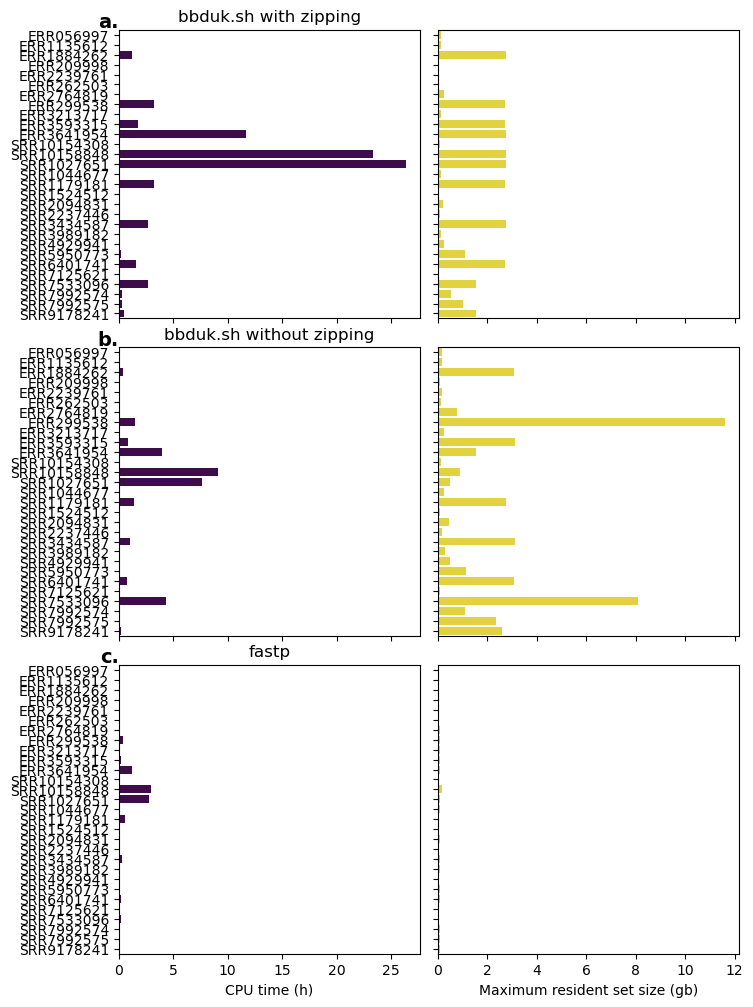

In [13]:
gs = gridspec.GridSpec(ncols=2, nrows=3, hspace=0.1, wspace=0.06)
fig = plt.figure(figsize=(8,12))

#ax_host_b = fig.add_subplot(gs[0, 1], sharey=ax_host)
ax_bbdukz_h = fig.add_subplot(gs[0,0])
ax_bbdukz_m = fig.add_subplot(gs[0, 1], sharey=ax_bbdukz_h)

ax_bbduk_h = fig.add_subplot(gs[1,0], sharex=ax_bbdukz_h)
ax_bbduk_m  = fig.add_subplot(gs[1,1], sharex=ax_bbdukz_m, sharey=ax_bbduk_h)

ax_fastp_h = fig.add_subplot(gs[2,0], sharex=ax_bbdukz_h)
ax_fastp_m = fig.add_subplot(gs[2,1], sharex=ax_bbdukz_m, sharey=ax_fastp_h)

x1 = 'cpu_time_h'
x2 = 'Maximum resident set size (gb)'

trimPalette = get_cmap(labels=[x1, x2])

# plot 
sns.barplot(
    data = trimTimesP.query("rule == 'trimmed_reads'"),
    x = x1,
    y = 'sample',
    color=trimPalette[x1],
    ax = ax_bbdukz_h
)

sns.barplot(
    data = trimTimesP.query("rule == 'trimmed_reads'"),
    x = x2,
    y = 'sample',
    color=trimPalette[x2],
    ax = ax_bbdukz_m
)


sns.barplot(
    data = trimTimesP.query("rule == 'trimmed_reads_unzipped'"),
    x = x1,
    y = 'sample',
    color=trimPalette[x1],
    ax = ax_bbduk_h
)

sns.barplot(
    data = trimTimesP.query("rule == 'trimmed_reads_unzipped'"),
    x = x2,
    y = 'sample',
    color=trimPalette[x2],
    ax = ax_bbduk_m
)

sns.barplot(
    data = trimTimesP.query("rule == 'trimming_thread1'"),
    x = x1,
    y = 'sample',
    color=trimPalette[x1],
    ax = ax_fastp_h
)

sns.barplot(
    data = trimTimesP.query("rule == 'trimming_thread1'"),
    x = x2,
    y = 'sample',
    color=trimPalette[x2],
    ax = ax_fastp_m
)

    
for i, (ax, title) in enumerate(zip([ax_bbdukz_h, ax_bbduk_h, ax_fastp_h], ['bbduk.sh with zipping', 'bbduk.sh without zipping', 'fastp'])):
    # -0.05, 1.05,
    ax.text(-0.0, 1.06, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
    ax.set_title(title)
    ax.set_ylabel('')
    
    if i < 2:
        ax.tick_params(labelbottom=False)
        ax.set_xlabel('')
    else:
        ax.set_xlabel('CPU time (h)')
        
    
for i, ax in enumerate([ax_bbdukz_m, ax_bbduk_m, ax_fastp_m]):
    ax.set_ylabel('')
    ax.tick_params(labelleft=False)
    
    if i < 2:
        ax.tick_params(labelbottom=False)
        ax.set_xlabel('')
        plt.setp(ax.get_xaxis().get_offset_text(), visible=False)
        
figure_saver(fig=fig, prefix='figures/trim_comparisons')

# Using KMA with references sequences from either Silva or mOTUs 

In [ ]:
rules = ['kma_silva', 'kma_mOTUs']
columns = ['cpu_time_h', 'Maximum resident set size (gb)']
collabels = {'cpu_time_h': 'CPU time (h)', 'Maximum resident set size (gb)': 'Maximum resident set size (gb)'}

gs = gridspec.GridSpec(ncols=len(columns), nrows=len(rules), hspace=0.1, wspace=0.06)
fig = plt.figure(figsize=(8,12))

axes = defaultdict(dict)
for i, rule in enumerate(rules):
    for j, col in enumerate(columns):
        if i == 0:
            ax = fig.add_subplot(gs[i, j])
        elif i > 0 and j == 0:
            ax = fig.add_subplot(gs[i,j], sharex=axes[i-1][j])
        else:
            ax = fig.add_subplot(gs[i,j], sharex=axes[i-1][j], sharey=axes[i][j-1])
        
        axes[i][j] = ax
        
        sns.barplot(
            data = dfs['32'].query(f"rule == @rule & sample in @samples29").dropna(subset=col),
            x = col,
            y = 'sample',
            color = trimPalette[col],
            ax = ax
        )
        
        if i == 0:
            ax.set_xlabel('')
            plt.setp(ax.get_xaxis().get_ticklabels(), visible=False)
            plt.setp(ax.get_xaxis().get_offset_text(), visible=False)
        elif i+1 == len(rules):
            ax.set_xlabel(collabels[col])
        
        if j == 0:
            ax.set_title(rule)
            ax.set_ylabel('')
            ax.text(-0.0, 1.06, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
        elif j == 1:
            ax.set_ylabel('')
            plt.setp(ax.get_yaxis().get_ticklabels(), visible=False)
figure_saver(fig=fig, prefix='figures/kma_comparisons')

# Final rules and their computational requirements

## averages + std

In [14]:
rule_order = ['raw_reads', 'trimming_thread1', 'kma_mOTUs', 'kma_gigaRes', 'seed_extender', 'mash_sketch']
pd.concat([dfs['32'], dfs['29_fastp']]).query("sample in @samples29 & rule in @rule_order").groupby(['rule'])[[x1, x2]].describe().round(3).loc[rule_order]

cpu_time_h                                                    \
                      count   mean    std    min    25%    50%    75%     max   
rule                                                                            
raw_reads              29.0  0.026  0.059  0.000  0.000  0.001  0.014   0.247   
trimming_thread1       29.0  0.310  0.756  0.000  0.002  0.010  0.179   2.966   
kma_mOTUs              29.0  2.590  5.306  0.004  0.015  0.143  2.685  20.235   
kma_gigaRes            29.0  0.474  0.897  0.000  0.001  0.030  0.437   3.571   
seed_extender          29.0  1.978  4.565  0.000  0.004  0.119  0.859  18.278   
mash_sketch            12.0  0.084  0.131  0.000  0.000  0.001  0.158   0.309   

                 Maximum resident set size (gb)                              \
                                          count   mean    std    min    25%   
rule                                                                          
raw_reads                                  29.0  0.003  0.000  0.003  0.003   
trimming_thread1                           29.0  0.059  0.037  0.001  0.022   
kma_mOTUs                                  29.0  0.682  0.000  0.681  0.682   
kma_gigaRes                                29.0  0.016  0.008  0.008  0.009   
seed_extender                              29.0  0.073  0.247  0.004  0.004   
mash_sketch                                12.0  0.000  0.000  0.000  0.000   

                                       
                    50%    75%    max  
rule                                   
raw_reads         0.003  0.003  0.003  
trimming_thread1  0.067  0.085  0.163  
kma_mOTUs         0.682  0.682  0.682  
kma_gigaRes       0.012  0.025  0.029  
seed_extender     0.022  0.030  1.340  
mash_sketch       0.000  0.000  0.000

## total compared to read sizes

In [161]:
samples29_meta = pd.read_csv('../data/29_samples_meta.csv', index_col=[0,1]).T

In [167]:
samples29_tot = pd.concat([dfs['32'], dfs['29_fastp']]).query("sample in @samples29 & rule in @rule_order").groupby(['sample'])[[x1, x2]].sum()

In [191]:
samples29_tot_meta = samples29_tot.merge(samples29_meta[['raw_bases']], left_index=True, right_index=True)
cols = [c for c in samples29_tot_meta.columns]
cols[-1] = cols[-1][0]
samples29_tot_meta.columns = cols 

samples29_tot_meta['raw_megabases'] = samples29_tot_meta['raw_bases'].astype(float) * 10**(-6)
samples29_tot_meta['raw_gigabases'] = samples29_tot_meta['raw_bases'].astype(float) * 10**(-9)

/var/folders/xn/wtz0b0kn1nlcb56q5mn_b8zw0000gp/T/ipykernel_24738/1436287116.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  samples29_tot_meta = samples29_tot.merge(samples29_meta[['raw_bases']], left_index=True, right_index=True)


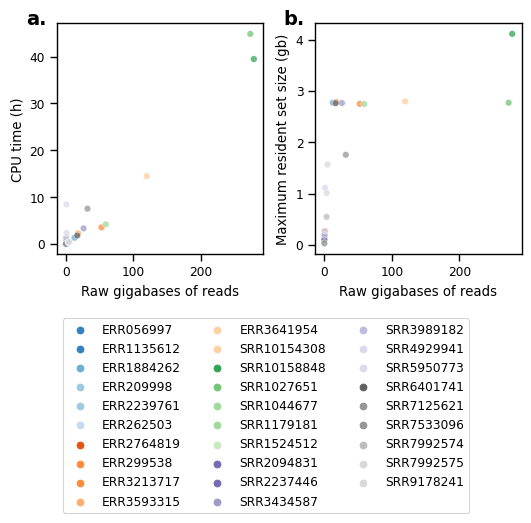

In [256]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(6,3), gridspec_kw={'wspace': .25})

sns.scatterplot(
    data = samples29_tot_meta.reset_index(),
    x = 'raw_gigabases',
    y = x1,
    ax = axes[0],
    hue = 'sample',
    palette = get_cmap(labels=samples29, name='tab20c'),
    alpha = .75
)
sns.scatterplot(
    data = samples29_tot_meta.reset_index(),
    x = 'raw_gigabases',
    y = x2,
    ax = axes[1],
    hue = 'sample',
    palette = get_cmap(labels=samples29, name='tab20c'),
    alpha = .75
)

axes[0].get_legend().remove()
axes[1].legend(loc='upper left', bbox_to_anchor=(-1.25,-.25), ncol=3)

for i, ax in enumerate(axes.flatten()):
    ax.set_xlabel('Raw gigabases of reads')
    ax.set_ylabel(collabels[ax.get_ylabel()])
    ax.text(-0.05, 1.06, alphabet[i] + '.', transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
    
figure_saver(fig=fig, prefix='figures/raw_tots')

In [273]:
samples29_tot_meta[f"{x1}/gb"] = samples29_tot_meta[x1]/samples29_tot_meta['raw_gigabases']
print(f"average per gb bases:", samples29_tot_meta[f"{x1}/gb"].mean())
print(f"median per gb bases:", samples29_tot_meta[f"{x1}/gb"].median())

average per gb bases: 0.9269766297070985
median per gb bases: 0.16434448016943914


In [ ]:
samples29_tot_meta[f"gb/{x1}"] = samples29_tot_meta[x1]/samples29_tot_meta['raw_gigabases']
print(f"average gb bases per {x1}:", samples29_tot_meta[f"gb/{x1}"].mean())
print(f"median gb bases per {x1}:", samples29_tot_meta[f"gb/{x1}"].median())